In [33]:
# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
import os
import zipfile

# Define paths for the zip file and extraction directory
zip_path = 'devnagari_digit.zip'  # Adjust filename if needed
extract_dir = 'dataset'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


# dataset/DevanagariHandwrittenDigitDataset/Train
# dataset/DevanagariHandwrittenDigitDataset/Test
root_dir = os.path.join(extract_dir, 'DevanagariHandwrittenDigitDataset')
train_dir = os.path.join(root_dir, 'Train')
test_dir = os.path.join(root_dir, 'Test')

# Verify that the directories exist
print(f"Training directory exists: {os.path.exists(train_dir)}")
print(f"Testing directory exists: {os.path.exists(test_dir)}")


Training directory exists: True
Testing directory exists: True


In [22]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

# Set image dimensions
img_height, img_width = 28, 28

def load_images_from_folder(folder_path):
    images, labels = [], []
    # Sort class folders by extracting the numeric part (assumes folder names are like "digit_0", "digit_1", ...)
    class_names = sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[-1]))
    class_map = {name: i for i, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(file_path).convert('L')  # Convert to grayscale
                img = img.resize((img_width, img_height))
                img_array = np.array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Skipping {file_path}: {e}")
                continue

    return np.array(images), np.array(labels)

# Assuming train_dir and test_dir are already defined from your previous extraction step
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)

# Reshape images to add a channel dimension (for grayscale: channel=1)
x_train = x_train.reshape(-1, img_height, img_width, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

# One-hot encode labels (10 classes: digits 0-9)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Check the shapes and a sample label
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("Unique labels (raw):", np.unique(np.argmax(y_train, axis=1)))


x_train shape: (17000, 28, 28, 1)
y_train shape: (17000, 10)
Unique labels (raw): [0 1 2 3 4 5 6 7 8 9]


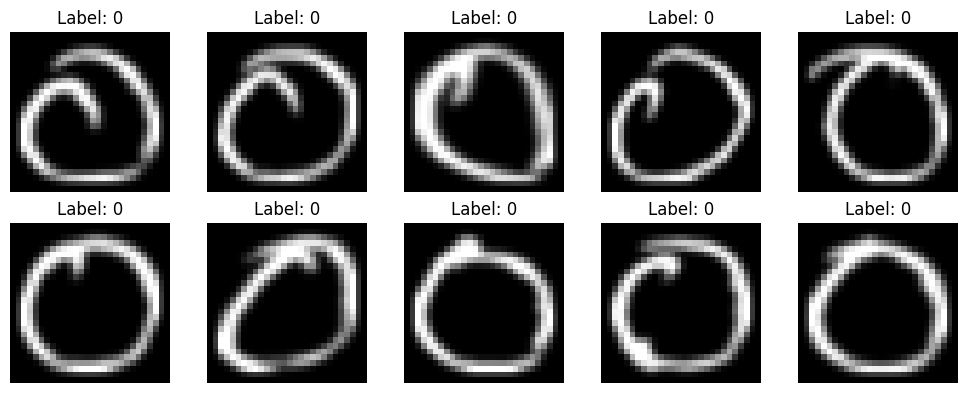

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense

# Define the FCN model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Flatten(),
    Dense(64, activation='sigmoid'),    # 1st hidden layer
    Dense(128, activation='sigmoid'),   # 2nd hidden layer
    Dense(256, activation='sigmoid'),   # 3rd hidden layer
    Dense(10, activation='softmax')       # Output layer: 10 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.2,
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)


Epoch 1/20
103/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2590 - loss: 2.0155
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2682 - loss: 1.9983 - val_accuracy: 0.0000e+00 - val_loss: 7.0188
Epoch 2/20
 98/107 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8038 - loss: 0.6451
Epoch 2: val_accuracy did not improve from 0.00000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8053 - loss: 0.6342 - val_accuracy: 0.0000e+00 - val_loss: 8.1694
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8553 - loss: 0.3394
Epoch 3: val_accuracy did not improve from 0.00000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8554 - loss: 0.3392 - val_accuracy: 0.0000e+00 - val_loss: 8.5460
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9016 - loss: 0.2597
Epoch 4: val_accuracy did not improve from 0.00000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0

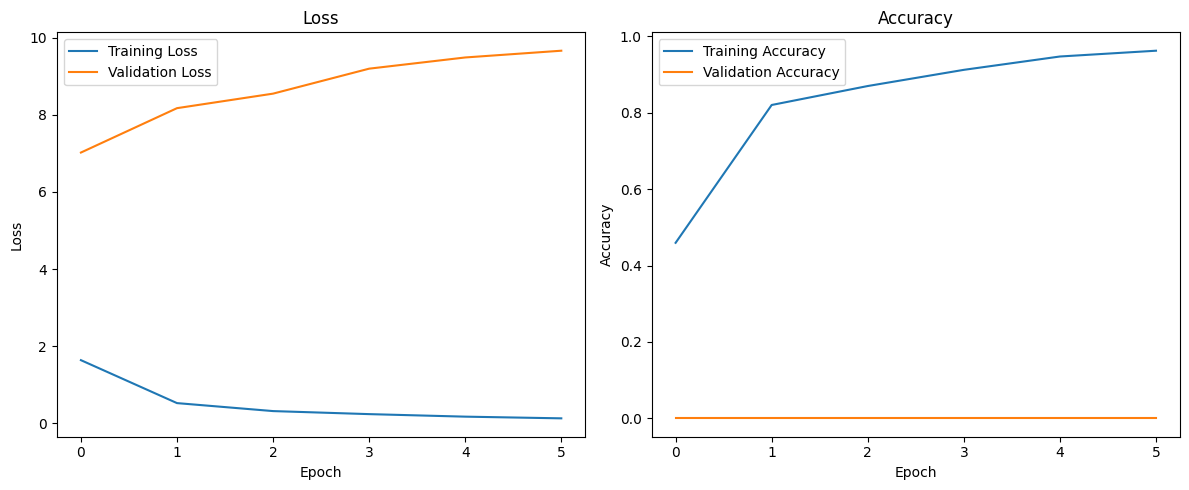

In [35]:
# Step 7: Plot Training and Validation Curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
# Step 8: Evaluate on Test Set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

94/94 - 0s - 4ms/step - accuracy: 0.7640 - loss: 2.0430
Test accuracy: 0.7640


In [37]:
print("y_train shape:", y_train.shape)
print("Sample label (before):", y_train[0])


y_train shape: (17000, 10)
Sample label (before): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [39]:
# Step 9: Save the Model (recommended format)
model.save("devnagari_fcn_model.keras")

In [40]:
# Step 10: Load the Model and Re-evaluate
loaded_model = tf.keras.models.load_model("devnagari_fcn_model.keras")
loaded_loss, loaded_acc = loaded_model.evaluate(x_test, y_test, verbose=2)
print(f"Loaded model test accuracy: {loaded_acc:.4f}")

/home/zero/.conda/envs/devnagari-fcn/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 - 1s - 6ms/step - accuracy: 0.7640 - loss: 2.0430
Loaded model test accuracy: 0.7640


In [29]:
# Predict on the test set
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Check the first prediction
print(f"Predicted label for first image: {predicted_labels[0]}")
print(f"True label for first image: {true_labels[0]}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicted label for first image: 0
True label for first image: 0


In [41]:
#Make Predictions
predictions = loaded_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

print(f"Predicted label for first image: {predicted_labels[0]}")
print(f"True label for first image: {np.argmax(y_test[0])}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted label for first image: 0
True label for first image: 0
